<a href="https://colab.research.google.com/github/bogatovam/qrl/blob/main/qrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-quantum -q
!pip install gym -q
!pip install qiskit -q
!pip install pylatexenc -q
!pip install mthree -q

     |████████████████████████████████| 7.8 MB 4.5 MB/s 
     |████████████████████████████████| 90 kB 4.7 MB/s 
     |████████████████████████████████| 5.6 MB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 27.0 MB/s 
     |████████████████████████████████| 100 kB 7.1 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 
     |████████████████████████████████| 1.5 MB 40.8 MB/s 
     |████████████████████████████████| 380 kB 26.4 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 695 kB/s 
     |████████████████████████████████| 93 kB 643 kB/s 
     |████████████████████████████████| 93 kB 1.0 MB/s 
     |████████████████████████████████| 93 kB 997 kB/s 
     |████████████████████████████████| 93 kB 174 kB/s 
     |████████████████████████████████| 93 kB 630 kB/s 
     |████████████████████████████████| 93 kB 914 kB/s 
     |████████████████████████████████| 92 kB 874 kB/s 
     |████████████████████████████████|

In [ ]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

In [ ]:
import qiskit
from numpy import pi
import sympy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

import mthree

In [ ]:
#General imports
import numpy as np

#Operator Imports
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

### Pytorch models

In [ ]:
def one_qubit_rotation(circuit, qubit, symbols):
    circuit.rx(symbols[0], qubit)
    circuit.ry(symbols[1], qubit)
    circuit.rz(symbols[2], qubit)

def encoding_layer(circuit, qubit, symbol):
   circuit.rx(symbol, qubit)

def entangling_layer(circuit, qubits):
    cz_ops = [circuit.cz(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([circuit.cz(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

class QuantumCircuit:
    
    def __init__(self, n_qubits, n_layers, expectation_operators, backend, shots):
        # ---------------------------
        # Define circuit
        # ---------------------------
        qreg_q = qiskit.QuantumRegister(n_qubits, 'q')
        self._circuit = qiskit.QuantumCircuit(qreg_q)

        # Sympy symbols for variational angles
        params_count = 3 * (n_layers + 1) * n_qubits
        self._params = [f'theta{i}'for i in range(params_count)]
        self._params = [qiskit.circuit.Parameter(param_name) for param_name in self._params]
        self._params = np.asarray(self._params).reshape((n_layers + 1, n_qubits, 3))
        
        # Sympy symbols for encoding angles
        self._inputs = [f'x{i}'+f'_{j}' for i in range(n_layers) for j in range(n_qubits)]
        self._inputs = [qiskit.circuit.Parameter(param_name) for param_name in self._inputs]
        self._inputs = np.asarray(self._inputs).reshape((n_layers, n_qubits))

        for l in range(n_layers):
          for i, q in enumerate(qreg_q): 
            one_qubit_rotation(self._circuit, q, self._params[l, i])

          entangling_layer( self._circuit, qreg_q)

          for i, q in enumerate(qreg_q):
            encoding_layer( self._circuit, q, self._inputs[l, i])

        # Last varitional layer
        for i, q in enumerate(qreg_q):
          one_qubit_rotation( self._circuit, q, self._params[n_layers, i])        

        # self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self._inputs = list(self._inputs.flat)
        self._params = list(self._params.flat)

        self.H = Z^Z^Z^Z
        self.op = ~StateFn(self.H) @ CircuitStateFn(primitive=self._circuit, coeff=1.)

        self.theta_grad = Gradient(grad_method='param_shift').convert(operator=self.op, params=self._params)
        self.input_grad = Gradient(grad_method='param_shift').convert(operator=self.op, params=self._inputs)
    
    def run(self, input, thetas):
        t_qc = transpile(self._circuit, self.backend)
        
        parameter_binds = {}
        parameter_binds.update({self._params[param_index]: param_value for param_index, param_value in enumerate(thetas)})
        parameter_binds.update({self._inputs[param_index]: param_value for param_index, param_value in enumerate(input)})

        return [self.op.assign_parameters(parameter_binds).eval().real]


    def compute_theta_gradient(self, input, thetas):
        parameter_binds = {}
        parameter_binds.update({self._params[param_index]: param_value for param_index, param_value in enumerate(thetas)})
        parameter_binds.update({self._inputs[param_index]: param_value for param_index, param_value in enumerate(input)})

        return self.theta_grad.assign_parameters(parameter_binds).eval()


    def compute_input_gradient(self, input, thetas):
        parameter_binds = {}
        parameter_binds.update({self._params[param_index]: param_value for param_index, param_value in enumerate(thetas)})
        parameter_binds.update({self._inputs[param_index]: param_value for param_index, param_value in enumerate(input)})

        return self.input_grad.assign_parameters(parameter_binds).eval()

Expected value for rotation pi [0.12024114903873634]


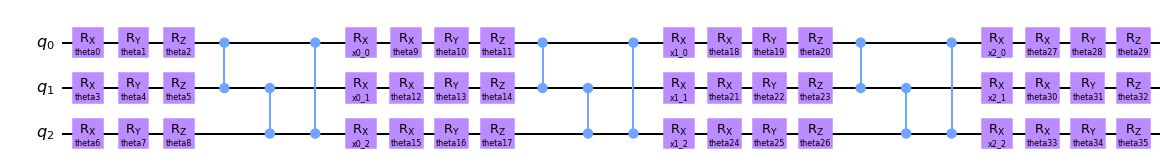

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')
test_n_qubits = 3
test_n_layers = 3
circuit = QuantumCircuit(test_n_qubits, test_n_layers, ['ZZZ'], simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run(np.ones(test_n_qubits * test_n_layers), np.ones(3 * (test_n_layers + 1) * test_n_qubits))))
circuit._circuit.draw(output='mpl')

In [ ]:
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, input, thetas, quantum_circuit, shift):
        
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        batch = input.shape[0]
        expectations = []
        for i in range(batch):
          expectation_z = ctx.quantum_circuit.run(input[i].tolist(), thetas[i].tolist())
          expectations.append(expectation_z)
          
        ctx.save_for_backward(input, torch.tensor(expectations), thetas)
        return torch.tensor(expectations)
        
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z, thetas = ctx.saved_tensors

        gradients = []
        input_gradients = []
        for i in range(input.shape[0]):
            gradient = ctx.quantum_circuit.compute_theta_gradient(input[i].tolist(), thetas[i].tolist())
            input_gradient = ctx.quantum_circuit.compute_input_gradient(input[i].tolist(), thetas[i].tolist())
            gradients.append(gradient)
            input_gradients.append(input_gradient)

        return torch.tensor(input_gradients).float(), torch.tensor(gradients).float(), None, None


class Hybrid(nn.Module):
    
    def __init__(self, n_qubits, n_layers, backend, shots, shift):
        super(Hybrid, self).__init__()
        
        self.quantum_circuit = QuantumCircuit(n_qubits, n_layers, ['Z' * n_qubits], backend, shots)
        self.shift = shift
        
    def forward(self, inputs, thetas):
        return HybridFunction.apply(inputs, thetas, self.quantum_circuit, self.shift)


class ReUploadingPQC(nn.Module):
    
    def __init__(self, n_qubits, n_layers, backend, shots, shift, use_activation = True):
        super(ReUploadingPQC, self).__init__()

        self._thetas_count = 3 * (n_layers + 1) * n_qubits
        self._x_count = n_layers * n_qubits
        self.n_layers = n_layers

        self.quantum_layer = Hybrid(n_qubits, n_layers, backend, shots, shift)
        self.thetas = nn.init.xavier_normal_(torch.empty(1, self._thetas_count, requires_grad=True))
        self.lmbd = torch.ones(self._x_count, requires_grad=True)

        self.thetas = torch.nn.Parameter(self.thetas)
        self.lmbd = torch.nn.Parameter(self.lmbd, requires_grad=True)

        self._use_activation = use_activation
        self._activation = nn.ReLU()
        
    def forward(self, inputs):
        tiled_up_inputs = torch.tile(inputs, [1, self.n_layers])
        tiled_up_thetas = torch.tile(self.thetas, [inputs.shape[0], 1])

        scaled_inputs = torch.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)

        x = self.quantum_layer(scaled_inputs, tiled_up_thetas)
        return x


class Alternating(nn.Module):
    
    def __init__(self,output_dim):
        super(Alternating, self).__init__()

        self.w = torch.tensor([[(-1.)**i for i in range(output_dim)]], requires_grad=True,dtype=torch.float64)
        self.w = torch.nn.Parameter(self.w)
        
    def forward(self, inputs):
        return torch.matmul(inputs, self.w)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

In [ ]:
class QuantumPolicyModel(nn.Module):
    def __init__(self, n_qubits, n_layers, n_actions, backend, beta=1.0):
        super(QuantumPolicyModel, self).__init__()

        self.re_uploading_pqc = ReUploadingPQC(n_qubits, n_layers, backend, 100, np.pi / 2)
        self.alternating = Alternating(n_actions)
        self.lambda_layer = LambdaLayer(lambda x: x * beta)
        self.n_actions = n_actions

    def forward(self, x):
        x = self.re_uploading_pqc(x)
        x = self.alternating(x)
        x = F.softmax(self.lambda_layer(x), dim=1)
        return x

#### Functions for reinforsment

In [ ]:
from collections import deque, defaultdict
import gym, cirq, sympy

def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = torch.tensor(normalized_states)
        action_probs = model(states)

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.tolist()):
            action = np.random.choice(n_actions, p=policy)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

#### Train model

In [ ]:
import tensorflow as tensorflow

In [ ]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

quantum_model = QuantumPolicyModel(n_qubits, n_layers, n_actions, qiskit.Aer.get_backend('aer_simulator'))

In [ ]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 1
n_episodes = 1000

In [ ]:
import functools 
import operator

def gather_nd(params, indices):
    '''
    the input indices must be a 2d tensor in the form of [[a,b,..,c],...], 
    which represents the location of the elements.
    '''
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1
    
    for i in range(ndim)[::-1]:
        idx += indices[i] * m 
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

In [ ]:
env_name = "CartPole-v1"
optimizer = optim.Adam(quantum_model.parameters(), lr=0.05)

def reinforce_update(states, actions, returns, model, optimizer):
    optimizer.zero_grad()
    states = torch.tensor(states)
    actions = torch.tensor(actions)
    returns = torch.tensor(returns)
    
    # print(f'states {states.shape}, actions {actions.shape}')
    logits = model(states)
    p_actions = gather_nd(logits, actions)
    log_probs = torch.log(p_actions)
    loss = torch.sum(-log_probs * returns) / batch_size
    loss.backward()
    optimizer.step()


# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, quantum_model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, quantum_model,optimizer)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)


Finished episode 1 Average rewards:  13.0
Finished episode 2 Average rewards:  17.5
Finished episode 3 Average rewards:  18.666666666666668
Finished episode 4 Average rewards:  17.75
Finished episode 5 Average rewards:  17.8
Finished episode 6 Average rewards:  27.166666666666668
Finished episode 7 Average rewards:  27.285714285714285
Finished episode 8 Average rewards:  28.125
Finished episode 9 Average rewards:  26.88888888888889
Finished episode 10 Average rewards:  26.5
Finished episode 11 Average rewards:  29.3
Finished episode 12 Average rewards:  29.1
Finished episode 13 Average rewards:  31.0
Finished episode 14 Average rewards:  34.0
Finished episode 15 Average rewards:  35.3
Finished episode 16 Average rewards:  31.3
Finished episode 17 Average rewards:  35.2
Finished episode 18 Average rewards:  36.0
Finished episode 19 Average rewards:  47.7
Finished episode 20 Average rewards:  51.6
Finished episode 21 Average rewards:  54.8
Finished episode 22 Average rewards:  61.0
Finis

In [ ]:
env_name = "CartPole-v1"
optimizer = optim.Adam(simple_model.parameters(), lr=0.01)

def reinforce_update(states, actions, returns, model, optimizer):
    # optimizer.zero_grad()
    states = torch.tensor(states)
    actions = torch.tensor(actions)
    returns = torch.tensor(returns)
    
    # print(f'states {states.shape}, actions {actions.shape}')
    logits = model(states)
    p_actions = gather_nd(logits, actions)
    log_probs = torch.log(p_actions)
    loss = torch.sum(-log_probs * returns) / batch_size
    loss.backward()
    optimizer.step()


# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, simple_model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, simple_model, optimizer)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 1000.0:
        break

Finished episode 1 Average rewards:  24.0
Finished episode 2 Average rewards:  22.5
Finished episode 3 Average rewards:  23.666666666666668
Finished episode 4 Average rewards:  27.0
Finished episode 5 Average rewards:  24.8
Finished episode 6 Average rewards:  27.166666666666668
Finished episode 7 Average rewards:  25.142857142857142
Finished episode 8 Average rewards:  23.875
Finished episode 9 Average rewards:  28.333333333333332
Finished episode 10 Average rewards:  27.8
Finished episode 11 Average rewards:  28.5
Finished episode 12 Average rewards:  28.6
Finished episode 13 Average rewards:  28.1
Finished episode 14 Average rewards:  25.4
Finished episode 15 Average rewards:  25.6
Finished episode 16 Average rewards:  24.1
Finished episode 17 Average rewards:  23.8
Finished episode 18 Average rewards:  23.9
Finished episode 19 Average rewards:  21.8
Finished episode 20 Average rewards:  27.8
Finished episode 21 Average rewards:  30.9
Finished episode 22 Average rewards:  34.3
Finis

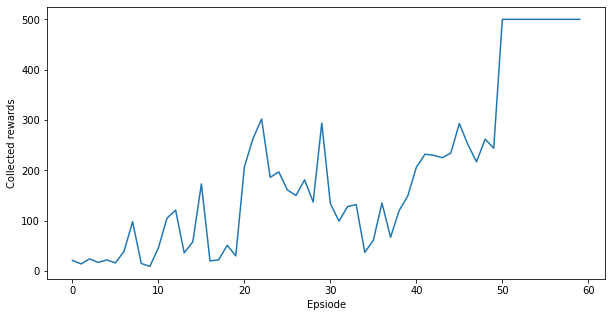

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()
